In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

In [3]:
df = pd.read_csv('car_sales_data.csv')
df.describe()

,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [4]:
df2 = pd.get_dummies(df, columns=['Manufacturer', 'Model', 'Fuel type'], drop_first=False)
df2

,Engine size,Year of manufacture,Mileage,Price,Manufacturer_BMW,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW,Model_718 Cayman,...,Model_Passat,Model_Polo,Model_Prius,Model_RAV4,Model_X3,Model_Yaris,Model_Z4,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Petrol
0,1.0,2002,127300,3074,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,4.0,2016,57850,49704,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,1.6,2014,39190,24072,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1.8,1988,210814,1705,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,1.0,2006,127869,4101,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.0,2018,28664,113006,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
49996,1.8,2003,105120,9430,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
49997,1.6,2022,4030,49852,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
49998,1.0,2016,26468,23630,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


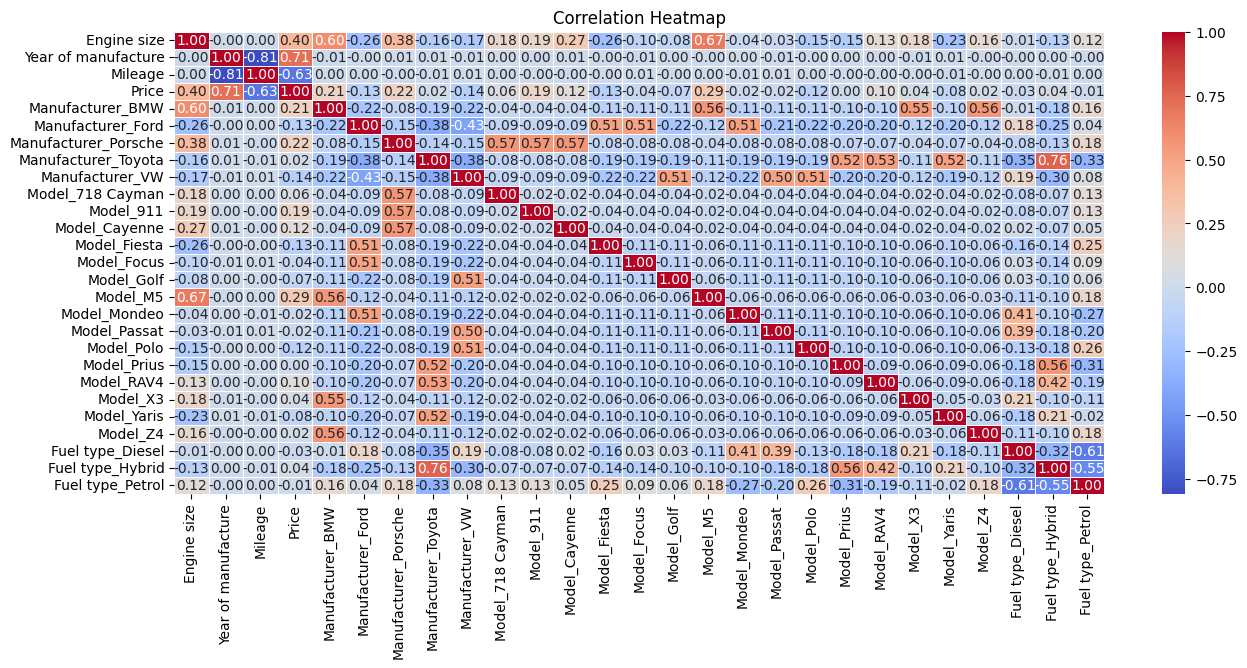

In [5]:
plt.figure(figsize=(15,6))
sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
y = df2['Price']
x = df2.drop(columns='Price')

results = []
for col in x.columns:
    X = sm.add_constant(df2[col])
    model = sm.OLS(y, X.astype(float)).fit()
    results.append({
        'Predictor': col,
        'Coefficient': model.params[col],
        'p-value': model.pvalues[col],
        'R^2': model.rsquared
    })

results_df = pd.DataFrame(results)
results_df

,Predictor,Coefficient,p-value,R^2
0,Engine size,8908.684163,0.000000e+00,0.158700
1,Year of manufacture,1215.528827,0.000000e+00,0.510095
2,Mileage,-0.145000,0.000000e+00,0.400299
3,Manufacturer_BMW,11769.241761,0.000000e+00,0.045969
4,Manufacturer_Ford,-4504.172880,5.299676e-175,0.015784
5,Manufacturer_Porsche,16115.783061,0.000000e+00,0.047662
6,Manufacturer_Toyota,682.928904,5.485304e-05,0.000325
7,Manufacturer_VW,-4938.814783,5.953305e-210,0.018943
8,Model_718 Cayman,7834.615744,3.466006e-44,0.003881
9,Model_911,23607.537057,0.000000e+00,0.035436


In [7]:
x_full = sm.add_constant(x)
model_final = sm.OLS(y, x_full.astype(float)).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     6598.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:40:27   Log-Likelihood:            -5.2487e+05
No. Observations:               50000   AIC:                         1.050e+06
Df Residuals:                   49980   BIC:                         1.050e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.229e+06   8686.356   -141.484      0.000   -1.25e+06   -1.21e+06
Engine size           3869.2606    125.796     30.758      0.000    3622.698    4115.823
Year of manufacture    988.1587      6.891    143.397      0.000     974.652    1001.665
Mileage                 -0.0377      0.001    -40.667      0.000      -0.040      -0.036
Manufacturer_BMW     -2.431e+05   1742.595   -139.516      0.000   -2.47e+05    -2.4e+05
Manufacturer_Ford    -2.491e+05   1737.895   -143.317      0.000   -2.52e+05   -2.46e+05
Manufacturer_Porsche -2.396e+05   1745.351   -137.287      0.000   -2.43e+05   -2.36e+05
Manufacturer_Toyota  -2.478e+05   1739.396   -142.446      0.000   -2.51e+05   -2.44e+05
Manufacturer_VW      -2.494e+05   1737.945   -143.507      0.000   -2.53e+05   -2.46e+05
Model_718 Cayman     -8.661e+04    630.918   -137.282      0.000   -8.79e+04   -8.54e+04
Model_911            -7.119e+04    628.191   -113.330      0.000   -7.24e+04      -7e+04
Model_Cayenne        -8.181e+04    634.834   -128.865      0.000   -8.31e+04   -8.06e+04
Model_Fiesta         -8.516e+04    591.309   -144.026      0.000   -8.63e+04    -8.4e+04
Model_Focus          -8.189e+04    588.305   -139.198      0.000    -8.3e+04   -8.07e+04
Model_Golf           -8.349e+04    588.178   -141.948      0.000   -8.46e+04   -8.23e+04
Model_M5             -7.073e+04    643.523   -109.918      0.000    -7.2e+04   -6.95e+04
Model_Mondeo         -8.202e+04    590.551   -138.880      0.000   -8.32e+04   -8.09e+04
Model_Passat         -8.098e+04    590.377   -137.166      0.000   -8.21e+04   -7.98e+04
Model_Polo           -8.494e+04    589.988   -143.965      0.000   -8.61e+04   -8.38e+04
Model_Prius          -8.268e+04    593.489   -139.307      0.000   -8.38e+04   -8.15e+04
Model_RAV4           -7.943e+04    593.543   -133.827      0.000   -8.06e+04   -7.83e+04
Model_X3             -8.556e+04    608.864   -140.532      0.000   -8.68e+04   -8.44e+04
Model_Yaris          -8.566e+04    592.101   -144.672      0.000   -8.68e+04   -8.45e+04
Model_Z4             -8.682e+04    608.375   -142.710      0.000    -8.8e+04   -8.56e+04
Fuel type_Diesel     -4.101e+05   2897.429   -141.528      0.000   -4.16e+05   -4.04e+05
Fuel type_Hybrid     -4.083e+05   2897.250   -140.937      0.000   -4.14e+05   -4.03e+05
Fuel type_Petrol     -4.106e+05   2896.082   -141.773      0.000   -4.16e+05   -4.05e+05
==============================================================================
Omnibus:                    34845.974   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1001212.553
Skew:                           2.989   Prob(JB):                         0.00
Kurtosis:                      24.091   Cond. No.                     2.20e+20
==================

In [8]:
y_pred = model_final.predict(x_full)
y_pred
df

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101
...,...,...,...,...,...,...,...
49995,BMW,M5,5.0,Petrol,2018,28664,113006
49996,Toyota,Prius,1.8,Hybrid,2003,105120,9430
49997,Ford,Mondeo,1.6,Diesel,2022,4030,49852
49998,Ford,Focus,1.0,Diesel,2016,26468,23630


In [9]:
mse = ((df['Price'] - y_pred)**2)
mse

0           233149.998984
1        101583429.298295
2           427555.516111
3          7570738.003489
4         10731123.290692
               ...       
49995    2922480515.70128
49996     25905052.445499
49997    252618746.680182
49998      1837273.945789
49999     50657509.683647
Length: 50000, dtype: object